<h1 align='center' style='background-color:yellow;'>Feature Engineering Assignment 1</h1> 

In [1]:
# Web Scrapper for IMDB Search
!pip install imdbpy

In [2]:
import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 152)
from dateutil.parser import parse
import dateutil.parser as dparser
from glob import glob
from imdb import IMDb
import matplotlib.pyplot as plt
import seaborn as sns

<h2 align='center' style='background-color:yellow;'>Q1. Identify and rectify the eight prominent data quality issues present in the given datasets</h2> 

In [3]:
class Bollywood:
    ''' Bollywood Class which contains the box office collection and social media promotion information 
        about the movies released in 2013 – 2015 period.  '''
    
    def __init__(self):
        ''' Constructor of Bollywood'''
        self.ia = IMDb()
        print('Bollywood Class Initiated')
        
    def convert_release_time(self, x):
        ''' To convert release time from categorical to number which is given in problem statement '''
        return pd.to_numeric(x.strip().lower().replace('fs','1').replace('hs','2').replace('lw','3').replace('n','4'))

    def convert_budget(self, x):
        ''' To clear budget column so that it should have only numbers '''
        return pd.to_numeric(x.strip().lower().replace('cr',''), downcast='float')

    def convert_genre(self, x):
        ''' Genre column has the word genre appended to few column values, so we are removing '''
        return x.strip().lower().replace('genre','')        

    def get_movie_release_date(self, movie_name, year, day = ''):
        ''' IMDB Scrapping - If the release date is in invalid format then fetch release date from imdb site '''
        movie_list = self.ia.search_movie(movie_name)
        movie_details = None
        if movie_list != None:
            movie = movie_list[0]
            self.ia.update(movie, 'release dates')
            release_dates = movie['release dates']
            print('\nMovie released across countries details')
            print(release_dates)
            print('\nFrom the above countries, selecting only india')
            for item in release_dates:
                if (year == '' or year in item) and ('india' in item.lower()) and (day =='' or (day != '' and day in item)):
                    print(item)
                    movie_details = parse(item,fuzzy=True)
                    break
        return movie_details

    def get_invalid_date(self, movie_id, year):
        ''' To identify invalid date'''
        try:
            year = year.strip()
            return parse(year).date()
        except ValueError as e:
            print(f"Not a valid date '{year}' for the movie id '{movie_id}' - reason: {e}")
            return year

    def valid_date(self, movie_name, year):
        ''' Validate date and if the date is not proper then get the release date from imdb using scrapper. '''
        try:
            year = year.strip()
            return parse(year)
        except ValueError as e:
            print('\n-----------------------------------------IMDB Movie Name-----------------------------------------')
            print(f"Not a valid date '{year}' for the movie '{movie_name}' - reason: {e}, so searching in IMDB")
            imdb_date = self.get_movie_release_date(movie_name, year[-4:])
            print('Final Movie Date : ' + str(imdb_date))
            return imdb_date
        
bollywood = Bollywood()

Bollywood Class Initiated


<h3 align='center' style='background-color:yellow;'>Data Quality Issues</h3>
<ol style='font-style:italic'>
  <li>Release Time - Convert string categorical data to numerical type</li>
  <li>Genre - Remove the word 'genre' appended</li>
  <li>Budget, BoxOfficeCollectionCr- Remove the word 'Cr' appended</li>
  <li>Youtube Columns - Filling NaN values by the formula YoutubeLikeDislikes = Youtube_Likes + Youtube_Dislikes</li>
  <li>Release Date - Invalid dates- Months are entered as Sqp, Jum, juu</li>
  <li>Release Time - Data Entry Issue - Entered 44 instead of 4</li>
  <li>Movie ID - Duplicate Entry - Same ID exists in both the datasets</li>
  <li>Same Movie ID with two different release date</li>
</ol>

In [4]:
# glob for reading multiple files based on pattern in filename
columns = ['Movie_ID', 'Release_Date', 'Movie_Name', 'Release_Time', 'Genre',
       'BudgetCr', 'BoxOfficeCollectionCr', 'Youtube_Views', 'Youtube_Likes',
       'Youtube_Dislikes','YoutubeLikeDislikes']
filenames = glob('bollywood*.csv')
df1, df2 = [pd.read_csv(f, names=columns,skiprows=1,
            converters={
                'Release_Time' : bollywood.convert_release_time,
                'Genre' : bollywood.convert_genre,
                'BudgetCr' : bollywood.convert_budget,
                'BoxOfficeCollectionCr' : bollywood.convert_budget,
            }) for f in filenames]

In [5]:
df1.head()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
0,51,4-Jul-14,Lekar Hum Deewana Dil,4,romance,16.0,2.50,3998331,2307,497,NaN
1,52,22-Mar-13,Aatma,4,thriller,8.0,8.78,841891,997,306,NaN
2,53,4-Apr-14,Main Tera Hero,3,comedy,40.0,55.00,4903941,12657,2139,NaN
3,54,22-Mar-13,Sona Spa,4,thriller,10.0,0.24,79430,61,112,NaN
4,55,29-Mar-13,Himmatwala,4,action,50.0,100.00,2501277,1,1,NaN


In [6]:
# Checking youtube information columns for Null
print(df1['Youtube_Likes'].isna().any())
print(df1['Youtube_Dislikes'].isna().any())
print(df1[df1['YoutubeLikeDislikes'].isna()].shape)

False
False
(99, 11)


In [7]:
# From the above information, df1 has NaN values in YoutubeLikeDislikes
# Adding Likes and dislikes will give likedislikes
df1['YoutubeLikeDislikes'] = df1.apply(lambda x: x.Youtube_Likes + x.Youtube_Dislikes, axis=1)

In [8]:
print(df1[df1['YoutubeLikeDislikes'].isna()].shape)

(0, 11)


In [9]:
df2.head()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
0,1,Apr-18-2014,2 States,3,romance,36.0,104.0,8576361,26622.0,2527.0,29149
1,2,Jan-4-2013,Table No. 21,4,thriller,10.0,12.0,1087320,1129.0,137.0,1266
2,3,Jul-18-2014,Amit Sahni Ki List,4,comedy,10.0,4.0,572336,586.0,54.0,640
3,4,Jan-4-2013,Rajdhani Express,4,drama,7.0,383.0,42626,86.0,19.0,105
4,5,Jul-4-2014,Bobby Jasoos,44,comedy,18.0,10.8,3113427,4512.0,1224.0,5736


In [10]:
print(df2['Youtube_Likes'].isna().any().sum())
print(df2['Youtube_Dislikes'].isna().any().sum())
print(df2['YoutubeLikeDislikes'].isna().any().sum())

1
1
0


In [11]:
display(df2[df2['Youtube_Likes'].isna()].head())
display(df2[df2['Youtube_Dislikes'].isna()].head())

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
39,40,Jun-20-2014,Humshakals,2,comedy,75.0,63.700001,6280868,NaN,1.0,2


,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
9,10,Jan-11-2013,Gangoobai,4,drama,2.0,0.01,4354,1.0,NaN,2
31,32,Feb-15-2013,Murder 3,1,thriller,12.0,25.00,2249055,1879.0,NaN,2626
46,47,Mar-15-2013,Mere Dad Ki Maruti,4,comedy,5.0,11.00,569711,1226.0,NaN,1359


In [12]:
# Filling Youtube_Likes Nan Values -> YoutubeLikeDislikes - Youtube_Dislikes
df2.loc[df2.Youtube_Likes.isna(),'Youtube_Likes'] = df2[df2.Youtube_Likes.isna()].apply(lambda x: x.YoutubeLikeDislikes - x.Youtube_Dislikes, axis=1)
# Filling Youtube_Dislikes Nan Values -> YoutubeLikeDislikes - Youtube_Likes
df2.loc[df2.Youtube_Dislikes.isna(),'Youtube_Dislikes'] = df2[df2.Youtube_Dislikes.isna()].apply(lambda x: x.YoutubeLikeDislikes - x.Youtube_Likes, axis=1)

In [13]:
# Again checking for youtube Nan Values
print(df2['Youtube_Likes'].isna().any().sum())
print(df2['Youtube_Dislikes'].isna().any().sum())
print(df2['YoutubeLikeDislikes'].isna().any().sum())

0
0
0


In [14]:
# Checking filled NaN values are correct or not
df2[df2['Movie_ID'].isin([40,10,32,47])]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
9,10,Jan-11-2013,Gangoobai,4,drama,2.0,0.010000,4354,1.0,1.0,2
31,32,Feb-15-2013,Murder 3,1,thriller,12.0,25.000000,2249055,1879.0,747.0,2626
39,40,Jun-20-2014,Humshakals,2,comedy,75.0,63.700001,6280868,1.0,1.0,2
46,47,Mar-15-2013,Mere Dad Ki Maruti,4,comedy,5.0,11.000000,569711,1226.0,133.0,1359


In [15]:
df2.tail()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
46,47,Mar-15-2013,Mere Dad Ki Maruti,4,comedy,5.0,11.000000,569711,1226.0,133.0,1359
47,48,Mar-15-2013,Jolly LLB,4,comedy,10.0,32.700001,1741424,3024.0,181.0,3205
48,49,May-09-2014,Koyelaanchal,2,action,8.0,2.000000,591838,347.0,31.0,378
49,50,May-2-2014,Kya Dilli Kya Lahore,2,drama,7.0,0.500000,492344,2018.0,64.0,2082
50,51,Jul-7-2014,Lekar Hum Deewana Dil,4,romance,16.0,2.500000,3998331,2307.0,497.0,2804


In [16]:
# Checking release date is valid in dataframe 1 - And printing invalid date
df1['Release_Date'] = df1.apply(lambda x: bollywood.get_invalid_date(x.Movie_ID, str(x.Release_Date)), axis=1)

In [17]:
# Checking release date is valid in dataframe 2 - And printing invalid date
df2['Release_Date'] = df2.apply(lambda x: bollywood.get_invalid_date(x.Movie_ID, str(x.Release_Date)), axis=1)

Not a valid date 'Sqp-19-2014' for the movie id '7' - reason: Unknown string format: Sqp-19-2014
Not a valid date 'Jum-27-2014' for the movie id '13' - reason: Unknown string format: Jum-27-2014
Not a valid date 'juu-6-2014' for the movie id '18' - reason: Unknown string format: juu-6-2014


In [18]:
# From the above invalid dates, we need to get valid dates from imdb
invalid_release_date_mid = [7, 13, 18]

In [19]:
# printing all the invalid dates
display(df2[df2['Movie_ID'].isin(invalid_release_date_mid)])

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
6,7,Sqp-19-2014,Daawat-E-Ishq,4,comedy,30.0,24.6,3905050,8315.0,1373.0,9688
12,13,Jum-27-2014,Ek Villain,2,romance,35.0,105.5,4518748,13558.0,1094.0,14652
17,18,juu-6-2014,Filmistaan,2,comedy,10.0,6.0,989096,1608.0,173.0,1781


In [20]:
# IMDB Scrapping - If the release date is in invalid format then fetch release date from imdb site
df1['Release_Date'] = df1.apply(lambda x: bollywood.valid_date(x.Movie_Name, str(x.Release_Date)), axis=1)
df2['Release_Date'] = df2.apply(lambda x: bollywood.valid_date(x.Movie_Name, str(x.Release_Date)), axis=1)


-----------------------------------------IMDB Movie Name-----------------------------------------
Not a valid date 'Sqp-19-2014' for the movie 'Daawat-E-Ishq' - reason: Unknown string format: Sqp-19-2014, so searching in IMDB

Movie released across countries details
['UK::5 September 2014', 'Singapore::5 September 2014', 'United Arab Emirates::18 September 2014', 'Kuwait::18 September 2014', 'Australia::19 September 2014', 'India::19 September 2014', 'Kenya::19 September 2014', 'Nepal::19 September 2014', 'Pakistan::19 September 2014', 'Thailand::19 September 2014', 'South Africa::19 September 2014', 'Netherlands::22 September 2014']

From the above countries, selecting only india
India::19 September 2014
Final Movie Date : 2014-09-19 00:00:00

-----------------------------------------IMDB Movie Name-----------------------------------------
Not a valid date 'Jum-27-2014' for the movie 'Ek Villain' - reason: Unknown string format: Jum-27-2014, so searching in IMDB

Movie released acros

In [21]:
# Checking if the invalid dates are properly updated
display(df2[df2['Movie_ID'].isin(invalid_release_date_mid)])

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
6,7,2014-09-19 00:00:00,Daawat-E-Ishq,4,comedy,30.0,24.6,3905050,8315.0,1373.0,9688
12,13,2014-06-27 00:00:00,Ek Villain,2,romance,35.0,105.5,4518748,13558.0,1094.0,14652
17,18,2014-06-06 00:00:00,Filmistaan,2,comedy,10.0,6.0,989096,1608.0,173.0,1781


In [22]:
# checking the dates are in proper date
df2.sort_values(by=['Release_Date']).head()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
34,35,0204-02-21 00:00:00,Highway,4,drama,30.0,27.25,3043012,9100.0,971.0,10071
1,2,2013-01-04 00:00:00,Table No. 21,4,thriller,10.0,12.00,1087320,1129.0,137.0,1266
3,4,2013-01-04 00:00:00,Rajdhani Express,4,drama,7.0,383.00,42626,86.0,19.0,105
7,8,2013-01-11 00:00:00,Matru Ki Bijlee Ka Mandola,4,comedy,33.0,40.00,2435283,4326.0,647.0,4973
9,10,2013-01-11 00:00:00,Gangoobai,4,drama,2.0,0.01,4354,1.0,1.0,2


In [23]:
# Movie_ID = 35 has invaid release dates - wrong date format
filtered_row = df2[df2['Movie_ID'] == 35]
filtered_row

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
34,35,0204-02-21 00:00:00,Highway,4,drama,30.0,27.25,3043012,9100.0,971.0,10071


In [24]:
# updating the correct release dates from imdb
df2.loc[df2.Movie_ID == 35, 'Release_Date'] = bollywood.get_movie_release_date(
    filtered_row.iloc[0]['Movie_Name'], 
    str(filtered_row.iloc[0]['Release_Date'].day)
)


Movie released across countries details
['Germany::13 February 2014                            (Berlin International Film Festival)', 'India::20 February 2014                            (Mumbai)', 'Kuwait::20 February 2014', 'UK::21 February 2014', 'Ireland::21 February 2014', 'India::21 February 2014', 'Pakistan::21 February 2014', 'USA::21 February 2014                            (limited)', 'Norway::28 September 2014                            (Bergen International Film Festival)', 'Taiwan::13 November 2014                            (Taipei Golden Horse Film Festival)']

From the above countries, selecting only india
India::21 February 2014


In [25]:
# checking the dates are in proper date
df2[df2['Movie_ID'] == 35]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
34,35,2014-02-21 00:00:00,Highway,4,drama,30.0,27.25,3043012,9100.0,971.0,10071


In [26]:
merged_df = df2.append(df1, ignore_index=True)
#merged_df.reset_index(inplace=True, drop=True)

In [27]:
#merged_df[['BudgetCr', 'BoxOfficeCollectionCr']] = merged_df[['BudgetCr','BoxOfficeCollectionCr']].astype(np.float64)
merged_df[['Release_Date']] = merged_df[['Release_Date']].astype(np.datetime64)

In [28]:
merged_df.shape

(150, 11)

In [29]:
merged_df.head()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
0,1,2014-04-18,2 States,3,romance,36.0,104.0,8576361,26622.0,2527.0,29149
1,2,2013-01-04,Table No. 21,4,thriller,10.0,12.0,1087320,1129.0,137.0,1266
2,3,2014-07-18,Amit Sahni Ki List,4,comedy,10.0,4.0,572336,586.0,54.0,640
3,4,2013-01-04,Rajdhani Express,4,drama,7.0,383.0,42626,86.0,19.0,105
4,5,2014-07-04,Bobby Jasoos,44,comedy,18.0,10.8,3113427,4512.0,1224.0,5736


In [30]:
merged_df['Release_Time'].unique()

array([ 3,  4, 44,  2,  1])

In [31]:
merged_df[merged_df['Release_Time'] == 44]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
4,5,2014-07-04,Bobby Jasoos,44,comedy,18.0,10.8,3113427,4512.0,1224.0,5736


In [32]:
# From the above results there is only one entry with Release_Time = 44
# Might be data entry issue, so replacing 44 with 4
merged_df.loc[merged_df['Release_Time'] == 44,'Release_Time'] = 4

In [33]:
# Checking whether it is updated or not
merged_df[merged_df['Movie_ID'] == 5]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
4,5,2014-07-04,Bobby Jasoos,4,comedy,18.0,10.8,3113427,4512.0,1224.0,5736


In [34]:
merged_df['Release_Time'].unique()

array([3, 4, 2, 1])

In [35]:
merged_df.dtypes

Movie_ID                          int64
Release_Date             datetime64[ns]
Movie_Name                       object
Release_Time                      int64
Genre                            object
BudgetCr                        float64
BoxOfficeCollectionCr           float64
Youtube_Views                     int64
Youtube_Likes                   float64
Youtube_Dislikes                float64
YoutubeLikeDislikes               int64
dtype: object

In [36]:
# checking if there is any null values in merged dataframe
merged_df.isnull().any()

Movie_ID                 False
Release_Date             False
Movie_Name               False
Release_Time             False
Genre                    False
BudgetCr                 False
BoxOfficeCollectionCr    False
Youtube_Views            False
Youtube_Likes            False
Youtube_Dislikes         False
YoutubeLikeDislikes      False
dtype: bool

In [37]:
# checking if there is any null values in merged dataframe
merged_df.isnull().sum()

Movie_ID                 0
Release_Date             0
Movie_Name               0
Release_Time             0
Genre                    0
BudgetCr                 0
BoxOfficeCollectionCr    0
Youtube_Views            0
Youtube_Likes            0
Youtube_Dislikes         0
YoutubeLikeDislikes      0
dtype: int64

In [38]:
merged_df.sort_values(by=['Release_Date']).head()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
1,2,2013-01-04,Table No. 21,4,thriller,10.0,12.00,1087320,1129.0,137.0,1266
3,4,2013-01-04,Rajdhani Express,4,drama,7.0,383.00,42626,86.0,19.0,105
7,8,2013-01-11,Matru Ki Bijlee Ka Mandola,4,comedy,33.0,40.00,2435283,4326.0,647.0,4973
9,10,2013-01-11,Gangoobai,4,drama,2.0,0.01,4354,1.0,1.0,2
15,16,2013-01-18,Bandook,4,action,4.0,0.09,28391,8.0,14.0,22


In [39]:
# to find out is there any duplicate by identity column Movie_ID
merged_df[merged_df.duplicated(['Movie_ID'])]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
51,51,2014-07-04,Lekar Hum Deewana Dil,4,romance,16.0,2.5,3998331,2307.0,497.0,2804


In [40]:
# to find out is there any duplicate by column Movie_Name
merged_df[merged_df.duplicated(['Movie_Name'])]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
51,51,2014-07-04,Lekar Hum Deewana Dil,4,romance,16.0,2.5,3998331,2307.0,497.0,2804


In [41]:
# from the above 2 statements, movie_id = 51 are duplicated
merged_df[merged_df.Movie_ID == 51]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
50,51,2014-07-07,Lekar Hum Deewana Dil,4,romance,16.0,2.5,3998331,2307.0,497.0,2804
51,51,2014-07-04,Lekar Hum Deewana Dil,4,romance,16.0,2.5,3998331,2307.0,497.0,2804


In [42]:
# but the movie_id = 51 has two different release_date
# also YoutubeLikeDislikes is updated in index = 51
# so lets drop row with index = 50 and update release_date with imdb scrapper
merged_df.drop_duplicates(subset ="Movie_ID", keep = 'first', inplace = True) 

In [43]:
merged_df[merged_df.Movie_ID == 51]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
50,51,2014-07-07,Lekar Hum Deewana Dil,4,romance,16.0,2.5,3998331,2307.0,497.0,2804


In [44]:
# when compared to imdb, release date is different, so updating from imdb
filtered_row = df2[df2['Movie_ID'] == 51]
merged_df.loc[merged_df.Movie_ID == 51, 'Release_Date'] = bollywood.get_movie_release_date(
    filtered_row.iloc[0]['Movie_Name'], 
    str(filtered_row.iloc[0]['Release_Date'].date().year)
)


Movie released across countries details
['India::4 July 2014', 'Pakistan::4 July 2014']

From the above countries, selecting only india
India::4 July 2014


In [45]:
merged_df[merged_df.Movie_ID == 51]

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
50,51,2014-07-04,Lekar Hum Deewana Dil,4,romance,16.0,2.5,3998331,2307.0,497.0,2804


In [46]:
merged_df.isna().sum()

Movie_ID                 0
Release_Date             0
Movie_Name               0
Release_Time             0
Genre                    0
BudgetCr                 0
BoxOfficeCollectionCr    0
Youtube_Views            0
Youtube_Likes            0
Youtube_Dislikes         0
YoutubeLikeDislikes      0
dtype: int64

In [47]:
merged_df.shape

(149, 11)

<h2 align='center' style='background-color:yellow;'>Q2. How many records are present in the dataset? Print the metadata information of dataset.</h2> 

In [48]:
print(str.format('Dataset 1 has {0} rows and {1} columns', df1.shape[0], df1.shape[1]))
print(str.format('Dataset 2 has {0} rows and {1} columns', df2.shape[0], df2.shape[1]))
print(str.format('Merged ds has {0} rows and {1} columns', merged_df.shape[0], merged_df.shape[1]))

Dataset 1 has 99 rows and 11 columns
Dataset 2 has 51 rows and 11 columns
Merged ds has 149 rows and 11 columns


In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Movie_ID               99 non-null     int64         
 1   Release_Date           99 non-null     datetime64[ns]
 2   Movie_Name             99 non-null     object        
 3   Release_Time           99 non-null     int64         
 4   Genre                  99 non-null     object        
 5   BudgetCr               99 non-null     float64       
 6   BoxOfficeCollectionCr  99 non-null     float64       
 7   Youtube_Views          99 non-null     int64         
 8   Youtube_Likes          99 non-null     int64         
 9   Youtube_Dislikes       99 non-null     int64         
 10  YoutubeLikeDislikes    99 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 8.6+ KB


In [50]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Movie_ID               51 non-null     int64  
 1   Release_Date           51 non-null     object 
 2   Movie_Name             51 non-null     object 
 3   Release_Time           51 non-null     int64  
 4   Genre                  51 non-null     object 
 5   BudgetCr               51 non-null     float64
 6   BoxOfficeCollectionCr  51 non-null     float64
 7   Youtube_Views          51 non-null     int64  
 8   Youtube_Likes          51 non-null     float64
 9   Youtube_Dislikes       51 non-null     float64
 10  YoutubeLikeDislikes    51 non-null     int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 4.5+ KB


In [51]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 149
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Movie_ID               149 non-null    int64         
 1   Release_Date           149 non-null    datetime64[ns]
 2   Movie_Name             149 non-null    object        
 3   Release_Time           149 non-null    int64         
 4   Genre                  149 non-null    object        
 5   BudgetCr               149 non-null    float64       
 6   BoxOfficeCollectionCr  149 non-null    float64       
 7   Youtube_Views          149 non-null    int64         
 8   Youtube_Likes          149 non-null    float64       
 9   Youtube_Dislikes       149 non-null    float64       
 10  YoutubeLikeDislikes    149 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 14.0+ KB


In [52]:
merged_df.isnull().any()

Movie_ID                 False
Release_Date             False
Movie_Name               False
Release_Time             False
Genre                    False
BudgetCr                 False
BoxOfficeCollectionCr    False
Youtube_Views            False
Youtube_Likes            False
Youtube_Dislikes         False
YoutubeLikeDislikes      False
dtype: bool

In [53]:
merged_df.describe()

,Movie_ID,Release_Time,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
count,149.000000,149.000000,149.000000,149.000000,1.490000e+02,149.000000,149.000000,149.000000
mean,75.000000,3.315436,29.442953,58.235369,3.337920e+06,7877.536913,1207.818792,9085.355705
std,43.156691,1.072300,28.237981,98.111494,3.504407e+06,12748.047191,1852.692938,14372.048371
min,1.000000,1.000000,2.000000,0.010000,4.354000e+03,1.000000,1.000000,2.000000
25%,38.000000,3.000000,11.000000,10.000000,1.076591e+06,1377.000000,189.000000,1637.000000
50%,75.000000,4.000000,21.000000,28.200001,2.375050e+06,4111.000000,614.000000,4913.000000
75%,112.000000,4.000000,35.000000,58.000000,4.550051e+06,9100.000000,1419.000000,10486.000000
max,149.000000,4.000000,150.000000,735.000000,2.317107e+07,101275.000000,11888.000000,111341.000000


<h2 align='center' style='background-color:yellow;'>Q3. How many movies in each genre got released in different release times?</h2> 

In [54]:
merged_df['Genre'].unique()

array(['romance', 'thriller', 'comedy', 'drama', 'action'], dtype=object)

In [55]:
merged_df.groupby(['Genre','Release_Time']).sum()

Movie_ID  BudgetCr  BoxOfficeCollectionCr  \
Genre    Release_Time                                              
action   1                  357     278.0             717.000000   
         2                  235     208.0             251.000000   
         3                  272     187.0             239.200001   
         4                  918     694.0             993.139997   
comedy   1                  369      93.0             404.000000   
         2                  225     102.0              87.300001   
         3                  352     200.0             436.500000   
         4                 1694     515.0             732.340004   
drama    1                  322      95.0             176.000000   
         2                  366     125.0             804.250000   
         3                   27     125.0             383.000000   
         4                 1882     502.0            1322.160001   
romance  1                  373      74.0              74.000000   
         2                  114      66.0             171.600000   
         3                  298      95.0             201.130000   
         4                 1070     394.0             874.300001   
thriller 1                  334     151.0             151.100000   
         2                  100      16.0              29.000000   
         3                  132      89.0             215.000000   
         4                 1735     378.0             415.050000   

                       Youtube_Views  Youtube_Likes  Youtube_Dislikes  \
Genre    Release_Time                                                   
action   1                  43610929       144477.0           19064.0   
         2                  12174200        27995.0            4677.0   
         3                  13989483        33164.0            4383.0   
         4                  66836981       196237.0           23683.0   
comedy   1                   1945982         7996.0            1604.0   
         2                  14428074         9257.0            3017.0   
         3                  15561095        29803.0           11958.0   
         4                  59377878       125194.0           19288.0   
drama    1                  15837920        50759.0            6424.0   
         2                  16551958        51599.0            6126.0   
         3                   6395202        37585.0           10269.0   
         4                  54740452       139134.0           13453.0   
romance  1                  12256792        25344.0            5380.0   
         2                  10061506        22569.0            3137.0   
         3                  12543091        31939.0            3378.0   
         4                  52021174        97389.0           14398.0   
thriller 1                   7273942        14464.0            4207.0   
         2                   3707889         3512.0            1292.0   
         3                  10690608        23376.0            2795.0   
         4                  67344911       101960.0           21432.0   

                       YoutubeLikeDislikes  
Genre    Release_Time                       
action   1                          163541  
         2                           32672  
         3                           37547  
         4                          219920  
comedy   1                            9600  
         2                           12274  
         3                           41761  
         4                          144482  
drama    1                           57183  
         2                           57725  
         3                           47854  
         4                          152587  
romance  1                           30724  
         2                           25706  
         3                           35317  
         4                          111787  
thriller 1                           18671  
         2                            4804  
         3         

In [56]:
q3 = pd.crosstab(merged_df.Release_Time, merged_df.Genre, margins=True, margins_name="Total",rownames=['Release Time'])
q3

Genre,action,comedy,drama,romance,thriller,Total
Release Time,,,,,,
1,3,3,4,3,4,17
2,3,5,6,3,1,18
3,3,5,1,4,2,15
4,15,23,24,15,22,99
Total,24,36,35,25,29,149


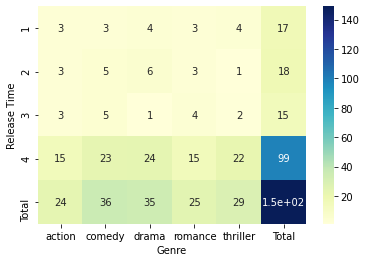

In [57]:
sns.heatmap(q3, cmap="YlGnBu", annot=True)

<h2 align='center' style='background-color:yellow;'>Q4. Which month of the year, maximum movie releases are seen?</h2> 

In [58]:
merged_df.set_index('Release_Date').groupby(pd.Grouper(freq="Y"))['Movie_ID'].head()

Release_Date
2013-01-04      2
2013-01-04      4
2013-01-11      8
2013-01-11     10
2013-01-18     12
2014-01-03     78
2014-01-03    113
2014-01-10      9
2014-01-10     84
2014-01-17     64
2015-01-09    137
2015-01-16    138
2015-01-23    139
2015-01-30    140
2015-01-30    141
Name: Movie_ID, dtype: int64

In [59]:
merged_df.set_index('Release_Date').groupby(pd.Grouper(freq="Y"))['Movie_ID'].agg('count')

Release_Date
2013-12-31    67
2014-12-31    70
2015-12-31    12
Freq: A-DEC, Name: Movie_ID, dtype: int64

In [60]:
movie_released = []
movie_year = []

In [61]:
# Filtering year = 2013
year_2013 = merged_df[ (merged_df['Release_Date'] <= pd.Timestamp('2013-12-31')) ].set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
movie_released.append(year_2013.max())
movie_year.append(str(year_2013.idxmax().date().strftime("%B")) + ' ' + str(year_2013.idxmax().date().year))

In [62]:
# Filtering year = 2014
year_2014 = merged_df[ (merged_df['Release_Date'] > pd.Timestamp('2013-12-31')) 
         & (merged_df['Release_Date'] <= pd.Timestamp('2014-12-31'))].set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
movie_released.append(year_2014.max())
movie_year.append(str(year_2014.idxmax().date().strftime("%B")) + ' ' + str(year_2014.idxmax().date().year))

In [63]:
# Filtering year = 2015
year_2015 = merged_df[ (merged_df['Release_Date'] > pd.Timestamp('2014-12-31')) 
         & (merged_df['Release_Date'] <= pd.Timestamp('2015-12-31'))].set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
movie_released.append(year_2015.max())
movie_year.append(str(year_2015.idxmax().date().strftime("%B")) + ' ' + str(year_2015.idxmax().date().year))

[Text(0, 0.5, 'Movie Released')]

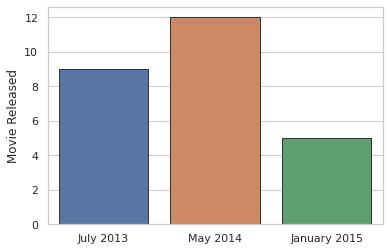

In [64]:
sns.set(style="whitegrid") #color="salmon", saturation=.5
sns.barplot(movie_year, movie_released, linewidth=1.0, errcolor=".2", edgecolor=".2").set(ylabel = "Movie Released")

In [65]:
# Filtering year = 2013, 2014, 2015
year_all = merged_df.set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
print('Max released : ' + str(year_all.max()))
print(str.format('Max released occured in the year {0} and month {1}',str(year_all.idxmax().date().year), str(year_all.idxmax().date().strftime("%B"))))

Max released : 12
Max released occured in the year 2014 and month May


<h2 align='center' style='background-color:yellow;'>Q5. Which month of the year typically sees most releases of high budgeted movies, that is, movies with budget of 25 crore or more?</h2>

In [66]:
movie_released = []
movie_year = []

In [67]:
merged_df[(merged_df['BudgetCr'] >= 25)].sort_values('Release_Date', ignore_index=True).head()

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes
0,8,2013-01-11,Matru Ki Bijlee Ka Mandola,4,comedy,33.0,40.000000,2435283,4326.0,647.0,4973
1,17,2013-01-25,Race 2,3,thriller,60.0,162.000000,7641333,12617.0,2138.0,14755
2,26,2013-02-08,Special 26,4,drama,42.0,103.000000,1829417,6248.0,568.0,6816
3,36,2013-02-22,Zilla Ghaziabad,4,action,36.0,16.000000,1551786,1753.0,619.0,2372
4,34,2013-02-22,Kai Po Che!,4,drama,30.0,62.200001,1888754,5686.0,512.0,6198


In [68]:
# Filtering year = 2013
year_2013= merged_df[(merged_df['BudgetCr'] >= 25) & (merged_df['Release_Date'] <= pd.Timestamp('2013-12-31')) ]\
.set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
movie_released.append(year_2013.max())
movie_year.append(str(year_2013.idxmax().date().strftime("%B")) + ' ' + str(year_2013.idxmax().date().year))

In [69]:
# Filtering year = 2014
year_2014 = merged_df[(merged_df['BudgetCr'] >= 25) &  (merged_df['Release_Date'] > pd.Timestamp('2013-12-31')) 
         & (merged_df['Release_Date'] <= pd.Timestamp('2014-12-31'))].set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
movie_released.append(year_2014.max())
movie_year.append(str(year_2014.idxmax().date().strftime("%B")) + ' ' + str(year_2014.idxmax().date().year))

In [70]:
# Filtering year = 2015
year_2015 = merged_df[(merged_df['BudgetCr'] >= 25) &  (merged_df['Release_Date'] > pd.Timestamp('2014-12-31')) 
         & (merged_df['Release_Date'] <= pd.Timestamp('2015-12-31'))].set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
movie_released.append(year_2015.max())
movie_year.append(str(year_2015.idxmax().date().strftime("%B")) + ' ' + str(year_2015.idxmax().date().year))

[Text(0, 0.5, 'Movie Released')]

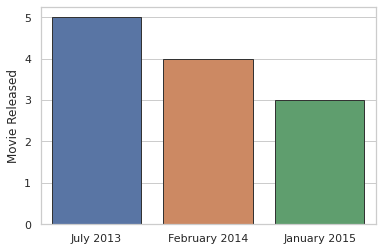

In [72]:
sns.set(style="whitegrid")
sns.barplot(movie_year, movie_released, linewidth=1.0, errcolor=".2", edgecolor=".2").set(ylabel = "Movie Released")

In [80]:
movie_released

[5, 4, 3]

In [73]:
# Filtering year = 2013, 2014, 2015
year_all = merged_df[(merged_df['BudgetCr'] >= 25)].set_index('Release_Date').groupby(pd.Grouper(freq="M")).agg('count')['Movie_ID']
print('Max released : ' + str(year_all.max()))
print(str.format('Max released occured in the year {0} and month {1}',str(year_all.idxmax().date().year), str(year_all.idxmax().date().strftime("%B"))))

Max released : 5
Max released occured in the year 2013 and month July


<h2 align='center' style='background-color:yellow;'>Q6. Which are the top 10 movies with maximum return of investment (ROI)? Calculate ROI as (Box office collection – Budget) / Budget.</h2>

In [74]:
# calculating ROI = ( BoxOfficeCollectionCr - BudgetCr) / BudgetCr
merged_df['ROI'] = (merged_df['BoxOfficeCollectionCr'] - merged_df['BudgetCr']) / merged_df['BudgetCr']

In [75]:
merged_df[['Movie_ID', 'Movie_Name', 'BudgetCr', 'BoxOfficeCollectionCr', 'ROI' ]].head()

,Movie_ID,Movie_Name,BudgetCr,BoxOfficeCollectionCr,ROI
0,1,2 States,36.0,104.0,1.888889
1,2,Table No. 21,10.0,12.0,0.200000
2,3,Amit Sahni Ki List,10.0,4.0,-0.600000
3,4,Rajdhani Express,7.0,383.0,53.714286
4,5,Bobby Jasoos,18.0,10.8,-0.400000


In [76]:
# displaying top 10 ROI details
df_top_roi = merged_df.sort_values(['ROI'], ascending = False).head(10)
df_top_roi

,Movie_ID,Release_Date,Movie_Name,Release_Time,Genre,BudgetCr,BoxOfficeCollectionCr,Youtube_Views,Youtube_Likes,Youtube_Dislikes,YoutubeLikeDislikes,ROI
3,4,2013-01-04,Rajdhani Express,4,drama,7.0,383.000000,42626,86.0,19.0,105,53.714286
65,65,2013-04-26,Aashiqui 2,4,romance,12.0,110.000000,2926673,4944.0,628.0,5572,8.166667
90,90,2014-12-19,PK,2,drama,85.0,735.000000,13270623,43767.0,5693.0,49460,7.647059
133,133,2013-09-13,Grand Masti,3,comedy,35.0,298.000000,1795640,3015.0,721.0,3736,7.514286
136,136,2013-09-20,The Lunchbox,4,drama,10.0,85.000000,1064854,4054.0,285.0,4339,7.500000
88,88,2013-06-14,Fukrey,4,comedy,5.0,36.200001,227912,222.0,39.0,261,6.240000
59,59,2014-09-05,Mary Kom,4,drama,15.0,104.000000,6086811,26560.0,1647.0,28207,5.933333
129,129,2013-10-18,Shahid,1,drama,6.0,40.000000,1148516,3155.0,396.0,3551,5.666667
37,38,2014-07-11,Humpty Sharma Ki Dulhania,4,romance,20.0,130.000000,6604595,14535.0,2208.0,16743,5.500000
102,102,2013-07-12,Bhaag Milkha Bhaag,4,drama,30.0,164.000000,2635390,4622.0,456.0,5078,4.466667


In [77]:
# Displaying top 10 ROI movies with Highlighting top 1 in green color
df_top_roi[['Movie_Name','ROI']].head(10).style\
.hide_index()\
.highlight_max(color='lightgreen')

Movie_Name,ROI
Rajdhani Express,53.714286
Aashiqui 2,8.166667
PK,7.647059
Grand Masti,7.514286
The Lunchbox,7.500000
Fukrey,6.240000
Mary Kom,5.933333
Shahid,5.666667
Humpty Sharma Ki Dulhania,5.500000
Bhaag Milkha Bhaag,4.466667


[Text(0, 0.5, 'Return of Investment')]

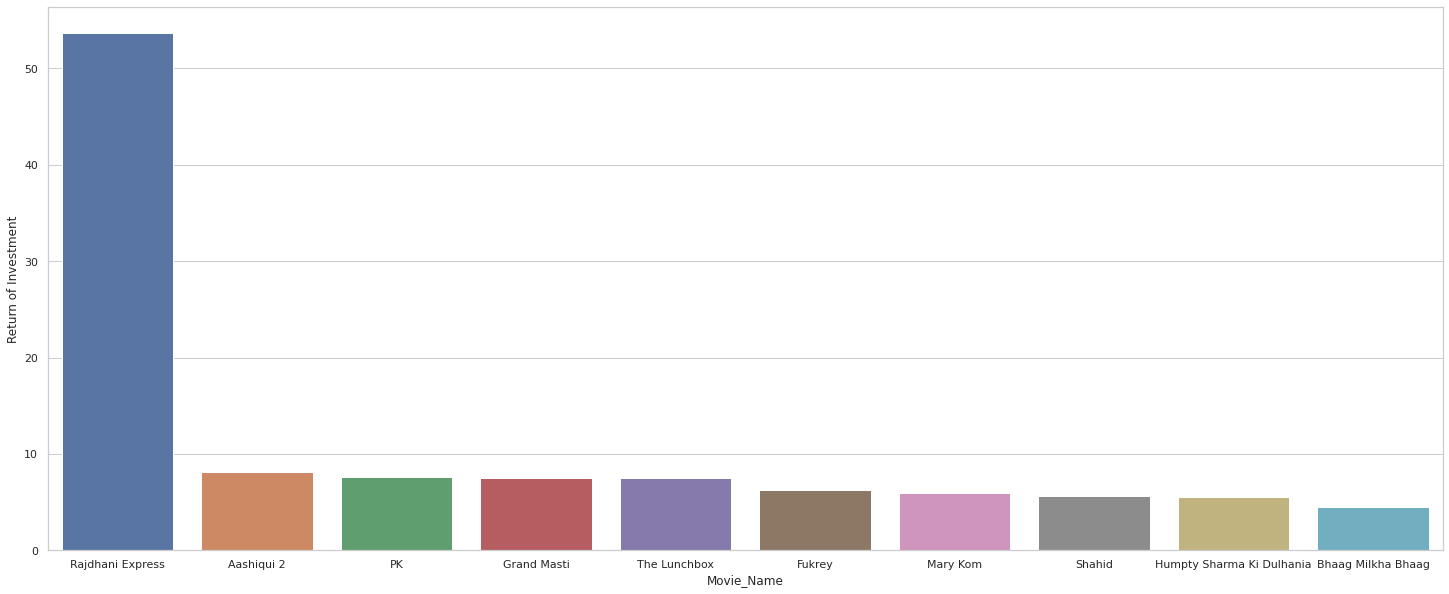

In [78]:
plt.figure(figsize=(25,10))
sns.set(style="whitegrid")
sns.barplot('Movie_Name', 'ROI', data = df_top_roi).set(ylabel = "Return of Investment")

In [79]:
print('END OF NOTEBOOK - THANK YOU')

END OF NOTEBOOK - THANK YOU
